# Capstone Project: Life in the "New Normal"
---

#### Organization of Project Notebooks:
- Notebook #1: [Problem Statement & Webscraping](./01_problem_statement_and_web_scraping.ipynb)
- Notebook #2: [Data Cleaning & Exploratory Data Analysis](./02_data_cleaning_and_eda.ipynb)
- Notebook #3: Preprocessing & Modelling
    - Notebook #3-1: [Preprocessing & Sentiment Analysis](./03-1_preprocessing_and_sentiment_analysis.ipynb)
    - Notebook #3-2: [Building Pre-trained LSTM RNN Model for Sentiment Analysis](./03-2_building_pretrained_lstm_model.ipynb) 
- **Notebook #4: Topic Modelling & Conclusion (current notebook)**
- Notebook #5: [Plotly & Dash Visualization](./05_plotly_and_dash.ipynb)

## Notebook #4: Topic Modelling & Conclusion

### Contents
1. [Introduction](#1.-Introduction)
2. [Preprocessing](#2.-Preprocessing)
3. [Topic Modelling](#3.-Topic-Modelling)
4. [Visualization of Topics & Sentiment](#4.-Visualization-of-Topics-&-Sentiment)
5. [Conclusion & Recommendations](#5.-Conclusion-&-Recommendations)
6. [Limitations & Further Explorations](#6.-Limitations-&-Further-Explorations)

### 1. Introduction

In this notebook, I will be conducting a Topic Modelling using Latent Dirichlet Allocation (LDA), to understand what people in Singapore are discussing on Twitter in recent times, and how the sentiment varies with the topics discussed. Topic Modelling refers to a group of unsupervised machine learning methods that is aimed at extracting meaningful and interpretable topics from a text corpus. It is helpful when understanding various types of text samples from a text dataset. 

In [68]:
# import the relevant packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize  
from nltk.stem import WordNetLemmatizer  
from sklearn.decomposition import LatentDirichletAllocation

import gensim
from gensim import corpora
import pyLDAvis
import pyLDAvis.gensim_models as gensimvis
from gensim.models.ldamodel import LdaModel
pyLDAvis.enable_notebook() 

pd.set_option('display.max_columns', None)
sns.set_style('whitegrid')
%config InlineBackend.figure_format = 'retina'
%matplotlib inline

warnings.filterwarnings('ignore')

In [2]:
# import the dataframe
sg_tweets_cleaned_df = pd.read_csv('../datasets/sg_tweets_cleaned_2021.csv')

### 2. Preprocessing
In this section, I will be passing the cleaned tweets obtained from a [previous notebook](./02_data_cleaning_and_eda.ipynb) through tokenization and lemmatization, to return the tokenized words in their lemma form, i.e. similar to the base/dictionary form of a word. Lemmatizing is preferred over stemming, as it is less likely to result in irregularities in English.

As compared to how the tweets are processed in the [earlier notebook for Sentiment Analysis](./03-1_preprocessing_and_sentiment_analysis.ipynb), I will be removing stop words here as stop words do not necessarily aid in the prediction of the topics.

In [3]:
# view top 5 rows 
sg_tweets_cleaned_df.head()

,id,date,tweet,language,hashtags,user_id,username,nlikes,nreplies,nretweets,near,date_only,month,year,hour,char_length,word_count,num_hashtag,num_mentions,cleaned_tweet
0,1355666922210164738,2021-01-31 07:59:15,@zettodot Haha! I know who you feel!,en,[],1269471373912535040,AuraGuardians2,1,0,0,Singapore,2021-01-31,1,2021,7,36,7,0,1,haha know who you feel
1,1355666319224397824,2021-01-31 07:56:52,Trained and smashed the pads and bags so hard ...,en,[],2252140291,EfashaKamarudin,1,0,0,Singapore,2021-01-31,1,2021,7,143,25,0,0,trained and smashed the pads and bags so hard ...
2,1355665910283948036,2021-01-31 07:55:14,@zettodot I checking with you all. Excalty lev...,en,[],1269471373912535040,AuraGuardians2,1,1,0,Singapore,2021-01-31,1,2021,7,80,16,0,1,checking with you all excalty level to max al...
3,1355664963931570178,2021-01-31 07:51:29,Breakfast https://t.co/gN80tfjySA,en,[],971573083483004929,nenipuspitasar_,1,0,0,Singapore,2021-01-31,1,2021,7,34,2,0,0,breakfast
4,1355664076957880320,2021-01-31 07:47:57,@zettodot Don't give up until the event end!,en,[],1269471373912535040,AuraGuardians2,1,0,0,Singapore,2021-01-31,1,2021,7,44,8,0,1,don give up until the event end


In [4]:
# instantiate the lemmatizier
lemmatizer = WordNetLemmatizer()

# set up the lemmatizer
lemmatized_tweets = []
for tweet in sg_tweets_cleaned_df['cleaned_tweet']:
    word_tokens = word_tokenize(tweet)
    
    stop_words = set(stopwords.words('english')) 
    word_tokens_wosw = [w for w in word_tokens if not w in stop_words]

    tweet = [lemmatizer.lemmatize(word) for word in word_tokens_wosw]
    lemmatized_tweets.append(' '.join(tweet))
    
# append the lemmatized tweets to the DataFrame
sg_tweets_cleaned_df['lemmatized_tweet'] = lemmatized_tweets

### 3. Topic Modelling

In this section, to identify topics from the preprocessed tweets, I will be utilising Latent Dirichlet Allocation (LDA) from Gensim. LDA considers each document (i.e. each row of tweet) as a collection of topics and each topic as a collection of keywords in various proportions.

### 3.1 Creating bigrams and applying filters

To build the LDA model, I will first identify bigrams, which are phrases containing two words such as 'social' and 'media' and are likely to occur together as 'social media' than individually. The Pointwise Mutual Information (PMI) score will be used to identify crucial bigrams for concatenation, where two words with high PMI score indicates good collocation pairs, i.e. the probability of co-occurrence is only slightly lower than the probabilities of occurrence of each word. Filters will also be applied based on frequency and noun-type structures.

In [5]:
# define bigrams 
bigram_measures = nltk.collocations.BigramAssocMeasures()
finder = nltk.collocations.BigramCollocationFinder.from_documents([comment.split() for comment in sg_tweets_cleaned_df['lemmatized_tweet']])

# filter only bigrams that occur at least 50 times
finder.apply_freq_filter(50)
bigram_scores = finder.score_ngrams(bigram_measures.pmi)

In [6]:
# store the bigram scores as a dataframe
bigram_pmi = pd.DataFrame(bigram_scores)
bigram_pmi.columns = ['bigram', 'pmi']
bigram_pmi.sort_values(by='pmi', axis = 0, ascending = False, inplace = True)

In [28]:
# view the top 5 rows in the dataframe
bigram_pmi.head()

,bigram,pmi
0,"(gelang, patah)",15.074856
1,"(asismytianomgbabymytianomg, mytianomglove)",15.029768
2,"(visio, optical)",14.964673
3,"(pantheon, percussion)",14.821670
4,"(godnigel, omgajusshi)",14.766734


In [7]:
# create a function to filter bigrams with only noun-type structues
def bigram_filter(bigram):
    tag = nltk.pos_tag(bigram)
    if tag[0][1] not in ['JJ', 'NN'] and tag[1][1] not in ['NN']:        # JJ refers to adjective (large); NN refers to singular noun
        return False
    if bigram[0] in stop_words or bigram[1] in stop_words:
        return False
    if 'n' in bigram or 't' in bigram:
        return False
    if 'PRON' in bigram:
        return False
    return True

In [8]:
# set pmi threshold to above 5
# choose top 500 bigrams in this case ranked by PMI that have noun like structures
filtered_bigram = bigram_pmi[bigram_pmi.apply(lambda bigram:\
                                              bigram_filter(bigram['bigram'])\
                                              and bigram.pmi>5, axis=1)][:500]

bigrams = [' '.join(x) for x in filtered_bigram.bigram.values if len(x[0])>2 or len(x[1])>2]

In [9]:
# view examples of bigrams
bigrams[:10]

['gelang patah',
 'pantheon percussion',
 'godnigel omgajusshi',
 'retained minn',
 'tik tok',
 'partipris foto',
 'sheng siong',
 'toa payoh',
 'safra energyone',
 'fort canning']

In [10]:
# create a function to concatenate bigrams
def replace_ngram(x):
    for gram in bigrams:
        x = x.replace(gram, '_'.join(gram.split()))
    return x

In [11]:
# save a copy of the original dataframe
reviews_w_ngrams = sg_tweets_cleaned_df.copy()

# apply function to concatenate bigrams
reviews_w_ngrams['lemmatized_tweet_ngram'] = reviews_w_ngrams['lemmatized_tweet'].map(lambda x: replace_ngram(x))

In [12]:
# tokenize reviews + remove stop words + remove words with less than 2 characters
reviews_w_ngrams = reviews_w_ngrams['lemmatized_tweet_ngram'].map(lambda x: [word for word in x.split()\
                                                                             if word not in stop_words\
                                                                             and len(word)>2])

In [13]:
# view the top 5 rows
reviews_w_ngrams.head()

0                                   [haha, know, feel]
1    [trained, smashed, pad, bag, hard, yesterday, ...
2    [checking, excalty, level, max, also, never, g...
3                                          [breakfast]
4                                   [give, event, end]
Name: lemmatized_tweet_ngram, dtype: object

As nouns are more likely to be indicators of a topic, I will be applying a filter to retain only the nouns among the texts of words.

In [14]:
# create a filter to retain only nouns
def noun_only(x):
    pos_comment = nltk.pos_tag(x)
    filtered = [word[0] for word in pos_comment if word[1] in ['NN']]
    # to filter both noun and verbs
    return filtered

In [15]:
# apply the function to retain only nouns
final_reviews = reviews_w_ngrams.map(noun_only)

With just the nouns being retained, a Dictionary will be created to map the words to their respective integer ids. Thereafter, the doc2bow() function will be utilised to count the number of occurrences of each word. 

In [16]:
# create a dictionary 
dictionary = corpora.Dictionary(final_reviews)

# count the frequency of each word
doc_term_matrix = [dictionary.doc2bow(doc) for doc in final_reviews]

### 3.2 Creating an LDA model

For LDA modelling, the number of topics that exists in a corpus of text needs to be specified. To determine the number of topics, I will utilise the Coherence score for a range of topic numbers. Coherence measures a single topic by the degree of semantic similarity between high scoring words in the topic – the higher the Coherence score, the higher the likelihood of obtaining the right number of topics.

In [17]:
# compute the coherence score for a range of topics
coherence = []
for k in range(5,25):
    print('Round: '+str(k))
    Lda = gensim.models.ldamodel.LdaModel
    ldamodel = Lda(doc_term_matrix, num_topics=k, id2word=dictionary, passes=40,\
                   iterations=200, chunksize=10000, eval_every=None)    
    cm = gensim.models.coherencemodel.CoherenceModel(model=ldamodel, texts=final_reviews,\
                                                     dictionary=dictionary, coherence='c_v')
    coherence.append((k,cm.get_coherence()))

Round: 5
Round: 6
Round: 7
Round: 8
Round: 9
Round: 10
Round: 11
Round: 12
Round: 13
Round: 14
Round: 15
Round: 16
Round: 17
Round: 18
Round: 19
Round: 20
Round: 21
Round: 22
Round: 23
Round: 24


In [18]:
# assign x to number of topics, and y to coherence score
x_val = [x[0] for x in coherence]
y_val = [x[1] for x in coherence]

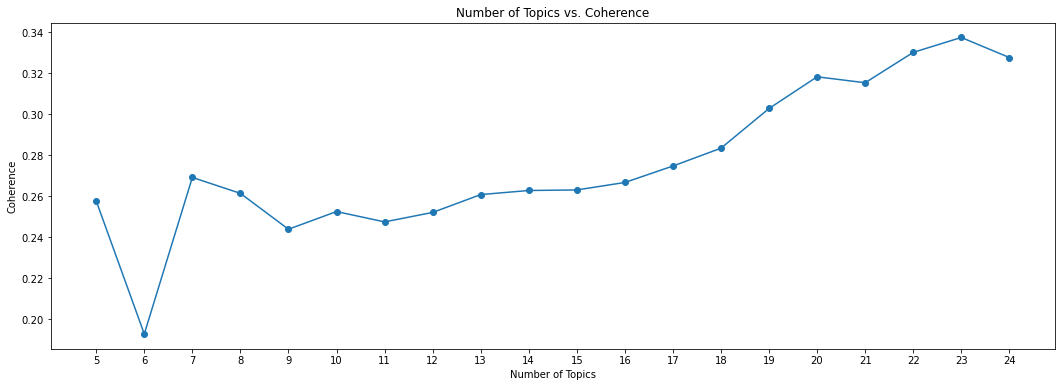

In [30]:
# plot a chart comparing the number of topics vs coherence score
plt.figure(figsize=(18,6))
plt.plot(x_val,y_val)
plt.scatter(x_val,y_val)
plt.title('Number of Topics vs. Coherence')
plt.xlabel('Number of Topics')
plt.ylabel('Coherence')
plt.xticks(x_val)
plt.show()

Based on the chart above, it seems that the Coherence score has a sharp improvement between six to seven topics, before declining, and thereafter gradually increasing from 11 topics and beyond. While the highest Coherence score is observed with 23 topics, it may not necessarily indicate that the corpus contains 23 distinct topics, especially if the same few words start appearing across multiple topics. 

Let's view the top keywords for these two groups of topics – 7 and 23 topics.

In [21]:
# trying with 23 topics
lda_model = LdaModel(doc_term_matrix, num_topics=23, id2word=dictionary, passes=40, 
                     iterations=200, chunksize=10000, eval_every=None, random_state=0)

In [22]:
# show keywords for 23 topics
lda_model.show_topics(23, num_words=10, formatted=False)

[(0,
  [('amp', 0.13847494),
   ('feel', 0.0573945),
   ('use', 0.041664943),
   ('strike', 0.029142514),
   ('anything', 0.02892585),
   ('project', 0.019584434),
   ('step', 0.018962802),
   ('village', 0.017535258),
   ('till', 0.015350873),
   ('pic', 0.014167248)]),
 (1,
  [('birthday', 0.06553606),
   ('lol', 0.064233035),
   ('lot', 0.04855875),
   ('number', 0.036306158),
   ('talk', 0.03277199),
   ('right', 0.03249676),
   ('wow', 0.030939376),
   ('hate', 0.027925078),
   ('head', 0.02670831),
   ('bit', 0.026011236)]),
 (2,
  [('work', 0.10248883),
   ('home', 0.067225836),
   ('hope', 0.044568516),
   ('food', 0.04048391),
   ('support', 0.03633536),
   ('story', 0.033581506),
   ('group', 0.027687123),
   ('share', 0.027541274),
   ('shot', 0.024540327),
   ('experience', 0.020738022)]),
 (3,
  [('world', 0.09920998),
   ('family', 0.059599504),
   ('news', 0.040958695),
   ('care', 0.039123245),
   ('reason', 0.032034855),
   ('girl', 0.030916883),
   ('dont', 0.02859177

In [31]:
# trying with 7 topics
lda_model2 = LdaModel(doc_term_matrix, num_topics=7, id2word=dictionary, passes=40,
                      iterations=200, chunksize=10000, eval_every=None, random_state=0)

In [32]:
# show keywords for 7 topics
lda_model2.show_topics(7, num_words=10, formatted=False)

[(0,
  [('man', 0.022215165),
   ('something', 0.0162497),
   ('feel', 0.015886107),
   ('nothing', 0.012145486),
   ('country', 0.011586633),
   ('friend', 0.01107173),
   ('see', 0.010795226),
   ('fun', 0.009407048),
   ('power', 0.008597682),
   ('problem', 0.008564929)]),
 (1,
  [('look', 0.02441653),
   ('please', 0.023186969),
   ('need', 0.021211896),
   ('someone', 0.01785617),
   ('birthday', 0.016775265),
   ('lol', 0.016441714),
   ('help', 0.016155936),
   ('way', 0.014099188),
   ('person', 0.011993121),
   ('congratulation', 0.009702851)]),
 (2,
  [('life', 0.03151799),
   ('work', 0.018863492),
   ('place', 0.014387752),
   ('food', 0.0143466145),
   ('hope', 0.012493171),
   ('time', 0.011678575),
   ('heart', 0.0113351075),
   ('word', 0.009634419),
   ('everything', 0.009401002),
   ('today', 0.00800387)]),
 (3,
  [('thing', 0.04306093),
   ('everyone', 0.02611566),
   ('baby', 0.017943742),
   ('bro', 0.012587296),
   ('cute', 0.011880433),
   ('week', 0.011497292),

Based on the top keywords obtained from each topic, the keywords from identifying 7 topics (LDA Model #2) seem to be more distinct than the keywords from identifying 23 topics (LDA Model #1). Additionally, some of the overall topics under LDA Model #1 seem to be overlapping. 

From LDA Model #2, it can be slightly challenging to deduce what the topics represent from just the 10 keywords, for instance:
- Topic 5 may be related to exploring new places of interest in Singapore and taking photos/videos for sharing. 
- Topic 6 may be related to the military coup in Myanmar.

To aid in the interpretation of the topics, the pyLDAvis tool can be employed. 

### 3.3 Visualizing the topics identified and their keywords

Over here, I will be using the pyLDAvis tool to create a visualization of the topics and their keywords, as this interactive tool allows the following interpretations to be derived: 
- Each circle represents a topic, and the distance between the circles indicates how related the topics are to one another. 
- The size of each circle reveals the proportion of tokens in the corpus that it constitutes.

Additionally, in the earlier section, some words in a given topic occur more frequently than others in the corpus, thereby allowing them to be identified as top keywords. As this may not be the most comprehensive method in determining the top keywords for each topic, the Relevancy score can be utilised to prioritise terms that belong more exclusively to the identified topic, thus enhancing the topics' interpretability. 
- The pyLDAvis tool allows for adjustment to the value of lambda (a component used in the computation of the Relevancy score), to allocate higher weightage to words which are more relevant to the identified topic.

In [33]:
# plot visualization
topic_data = gensimvis.prepare(lda_model2, doc_term_matrix, dictionary, mds='pcoa')
pyLDAvis.display(topic_data)

Based on the above plot, it can be observed that: 
- The topics identified are relatively distinct, despite some overlaps between Topics 1 and 3, and Topics 4 and 6. 
- Topic 1 contains the highest proportion of tokens in the corpus (18.6%), whereas Topic 7 contains the least proportion of tokens (11.4%). 
- The interpretability of each topic seems to improve when lambda is adjusted downwards from 1 to 0.1.

Let's extract the top 15 keywords for each topic, with a lambda value of 0.25.

In [38]:
# extract the words for lambda 0.25
all_topics = {}
num_terms = 15 
lambd = 0.25
for i in range(1,8): 
    topic = topic_data.topic_info[topic_data.topic_info.Category == 'Topic'+str(i)].copy()
    topic['relevance'] = topic['loglift']*(1-lambd)+topic['logprob']*lambd
    all_topics['Topic '+str(i)] = topic.sort_values(by='relevance', ascending=False).Term[:num_terms].values
    
# store the topics and their terms in a dataframe
topics_df = pd.DataFrame(all_topics).T
topics_df

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
Topic 1,day,year,time,love,game,guy,wait,month,case,covid,end,song,vaccine,play,wow
Topic 2,thank,morning,night,myanmar,junta,haha,damn,god,body,head,china,cry,water,sia,dictatorship
Topic 3,life,place,food,hope,heart,word,market,mind,join,centre,hate,eat,state,student,work
Topic 4,look,please,need,someone,birthday,lol,help,person,congratulation,talk,right,think,question,phone,stop
Topic 5,singapore,photo,video,johor_bahru,boy,bukit_panjang,shot,park,hotel,guess,july,dinner,coffee,tonight,want
Topic 6,man,something,feel,nothing,see,fun,power,problem,strike,anything,movie,silver_chef_bistro,side,fact,line
Topic 7,thing,everyone,baby,bro,cute,face,fuck,tweet,girl,terrorist,check,dont,miss,wan_na,hair


From the top terms, it can be deduced that: 
- Topic 1 seems to contain a mixture of latest trends such as the Premier League games, COVID-19 cases and vaccinations. 
- Topic 2 seems to be related to the military coup in Myanmar, and with some form of reference to China's dictatorship.
- Topic 3 seems to be related to COVID-19, but surrounding the COVID-19 clusters in food centres and marketplaces, and restrictions imposed on dining-in. There seems to be some reference to working from home and students having web-based learning.
- Topic 4 seems to be related to occasions such as birthdays and congratulatory events. 
- Topic 5 seems to be related to recreational activities amidst COVID-19, such as exploring nature and food places, as well as going on staycations.
- Topic 6 seems to contain a mixture of online trends such as movie and food places, as well as personal opinions and problems that users are willing to voice out online.
- Topic 7 seems to be related to political affairs in the United States of America.


While each document is made up of multiple topics in LDA, it is likely that only one of the topics is dominant. Let's extract the dominant topic from each document and the associated weight of the dominant topic.

In [75]:
# create a function to assign each row of tweet to its dominant topic

def format_topics_sentences(ldamodel, corpus, texts):

    # initiate an output
    sent_topics_df = pd.DataFrame()

    # obtain the main topic in each document
    for i, row_list in enumerate(ldamodel[corpus]):
        row = row_list[0] if ldamodel.per_word_topics else row_list            
    
        # print row
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        
        # obtain the dominant topic and topic percentage contribution for each document 
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0: 
                wp = ldamodel.show_topic(topic_num)
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4)]), ignore_index=True)
            else:
                break
    
    sent_topics_df.columns = ['dominant_topic', 'perc_contribution']

    # add a column for the original lemmatized tweet
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return(sent_topics_df)

In [76]:
# create a copy of the dataframe with the lemmatized tweet
lem_tweets_df = sg_tweets_cleaned_df.copy()

# apply function to obtain the dominant topics
topic_sents_keywords_df = format_topics_sentences(ldamodel=lda_model2, 
                                                  corpus=doc_term_matrix, 
                                                  texts=lem_tweets_df['lemmatized_tweet'].values.tolist())

In [78]:
# reformat the dataframe 
dominant_topic_df = topic_sents_keywords_df.reset_index()
dominant_topic_df.columns = ['document_no', 'dominant_topic', 'topic_perc_contrib', 'text']

# view the top 10 rows
dominant_topic_df.head(10)

,document_no,dominant_topic,topic_perc_contrib,text
0,0,0.0,0.3810,haha know feel
1,1,5.0,0.5182,trained smashed pad bag hard yesterday body fe...
2,2,4.0,0.3819,checking excalty level max also never give
3,3,4.0,0.5714,breakfast
4,4,6.0,0.3810,give event end
5,5,2.0,0.6286,woke go town sunday questioning life decision rn
6,6,2.0,0.2625,broker almost go bust hedge fund trade governm...
7,7,5.0,0.5714,morning mones
8,8,6.0,0.3810,give event end
9,9,4.0,0.3810,posted photo silver chef bistro


With the dominant topic and its associated weight identified for each document, let's merge them with the main DataFrame containing the sentiment labels of the tweets. 

In [79]:
# retain just the dominant_topic and topic_perc_contrib
dominant_topic_only_df = dominant_topic_df[['dominant_topic', 'topic_perc_contrib']]

In [84]:
# import the file saved during sentiment analysis
sg_tweets_sent_tm_df = pd.read_csv('../datasets/sg_tweets_sentiment_wso_2021.csv')

# view top 5 rows
sg_tweets_sent_tm_df.head()

,id,date,tweet,language,hashtags,user_id,username,nlikes,nreplies,nretweets,near,date_only,month,year,hour,char_length,word_count,num_hashtag,num_mentions,cleaned_tweet,lemmatized_tweet,sent_compound,sent_label,tb_polarity,tb_subjectivity,tb_label,lstm_label,week
0,1355666922210164738,2021-01-31 07:59:15,@zettodot Haha! I know who you feel!,en,[],1269471373912535040,AuraGuardians2,1,0,0,Singapore,2021-01-31,1,2021,7,36,7,0,1,haha know who you feel,haha know who you feel,0.4588,positive,0.200000,0.300000,positive,positive,4
1,1355666319224397824,2021-01-31 07:56:52,Trained and smashed the pads and bags so hard ...,en,[],2252140291,EfashaKamarudin,1,0,0,Singapore,2021-01-31,1,2021,7,143,25,0,0,trained and smashed the pads and bags so hard ...,trained and smashed the pad and bag so hard ye...,0.4996,positive,-0.197222,0.613889,negative,negative,4
2,1355665910283948036,2021-01-31 07:55:14,@zettodot I checking with you all. Excalty lev...,en,[],1269471373912535040,AuraGuardians2,1,1,0,Singapore,2021-01-31,1,2021,7,80,16,0,1,checking with you all excalty level to max al...,checking with you all excalty level to max als...,0.0000,positive,0.000000,0.000000,positive,positive,4
3,1355664963931570178,2021-01-31 07:51:29,Breakfast https://t.co/gN80tfjySA,en,[],971573083483004929,nenipuspitasar_,1,0,0,Singapore,2021-01-31,1,2021,7,34,2,0,0,breakfast,breakfast,0.0000,positive,0.000000,0.000000,positive,positive,4
4,1355664076957880320,2021-01-31 07:47:57,@zettodot Don't give up until the event end!,en,[],1269471373912535040,AuraGuardians2,1,0,0,Singapore,2021-01-31,1,2021,7,44,8,0,1,don give up until the event end,don give up until the event end,0.0000,positive,0.000000,0.000000,positive,negative,4


In [85]:
# merge sg_tweets_sent_tm_df with the topic dataframe
sg_tweets_sent_tm_df = pd.merge(left=sg_tweets_sent_tm_df,
                                right=dominant_topic_only_df,
                                how='left',
                                left_index=True,
                                right_index=True)

# view the top 5 rows
sg_tweets_sent_tm_df.head()

,id,date,tweet,language,hashtags,user_id,username,nlikes,nreplies,nretweets,near,date_only,month,year,hour,char_length,word_count,num_hashtag,num_mentions,cleaned_tweet,lemmatized_tweet,sent_compound,sent_label,tb_polarity,tb_subjectivity,tb_label,lstm_label,week,dominant_topic,topic_perc_contrib
0,1355666922210164738,2021-01-31 07:59:15,@zettodot Haha! I know who you feel!,en,[],1269471373912535040,AuraGuardians2,1,0,0,Singapore,2021-01-31,1,2021,7,36,7,0,1,haha know who you feel,haha know who you feel,0.4588,positive,0.200000,0.300000,positive,positive,4,0.0,0.3810
1,1355666319224397824,2021-01-31 07:56:52,Trained and smashed the pads and bags so hard ...,en,[],2252140291,EfashaKamarudin,1,0,0,Singapore,2021-01-31,1,2021,7,143,25,0,0,trained and smashed the pads and bags so hard ...,trained and smashed the pad and bag so hard ye...,0.4996,positive,-0.197222,0.613889,negative,negative,4,5.0,0.5182
2,1355665910283948036,2021-01-31 07:55:14,@zettodot I checking with you all. Excalty lev...,en,[],1269471373912535040,AuraGuardians2,1,1,0,Singapore,2021-01-31,1,2021,7,80,16,0,1,checking with you all excalty level to max al...,checking with you all excalty level to max als...,0.0000,positive,0.000000,0.000000,positive,positive,4,4.0,0.3819
3,1355664963931570178,2021-01-31 07:51:29,Breakfast https://t.co/gN80tfjySA,en,[],971573083483004929,nenipuspitasar_,1,0,0,Singapore,2021-01-31,1,2021,7,34,2,0,0,breakfast,breakfast,0.0000,positive,0.000000,0.000000,positive,positive,4,4.0,0.5714
4,1355664076957880320,2021-01-31 07:47:57,@zettodot Don't give up until the event end!,en,[],1269471373912535040,AuraGuardians2,1,0,0,Singapore,2021-01-31,1,2021,7,44,8,0,1,don give up until the event end,don give up until the event end,0.0000,positive,0.000000,0.000000,positive,negative,4,6.0,0.3810


In [86]:
# export file with topics as CSV
sg_tweets_sent_tm_df.to_csv('../datasets/sg_tweets_sentiment_topics_wso_2021.csv', index=False)

### 4. Visualization of Topics & Sentiment

In this section, I'm keen to understand how the dominant topics are distributed across the corpus of tweets, and the sentiment associated with these topics.

The overall distribution of the dominant topics for tweets from January to July 2021 is as follows:
0.0    0.179368
1.0    0.120737
2.0    0.123430
3.0    0.111913
4.0    0.146165
5.0    0.134219
6.0    0.184169
Name: dominant_topic, dtype: float64


[Text(0, 0, 'Topic 1'),
 Text(1, 0, 'Topic 2'),
 Text(2, 0, 'Topic 3'),
 Text(3, 0, 'Topic 4'),
 Text(4, 0, 'Topic 5'),
 Text(5, 0, 'Topic 6'),
 Text(6, 0, 'Topic 7')]

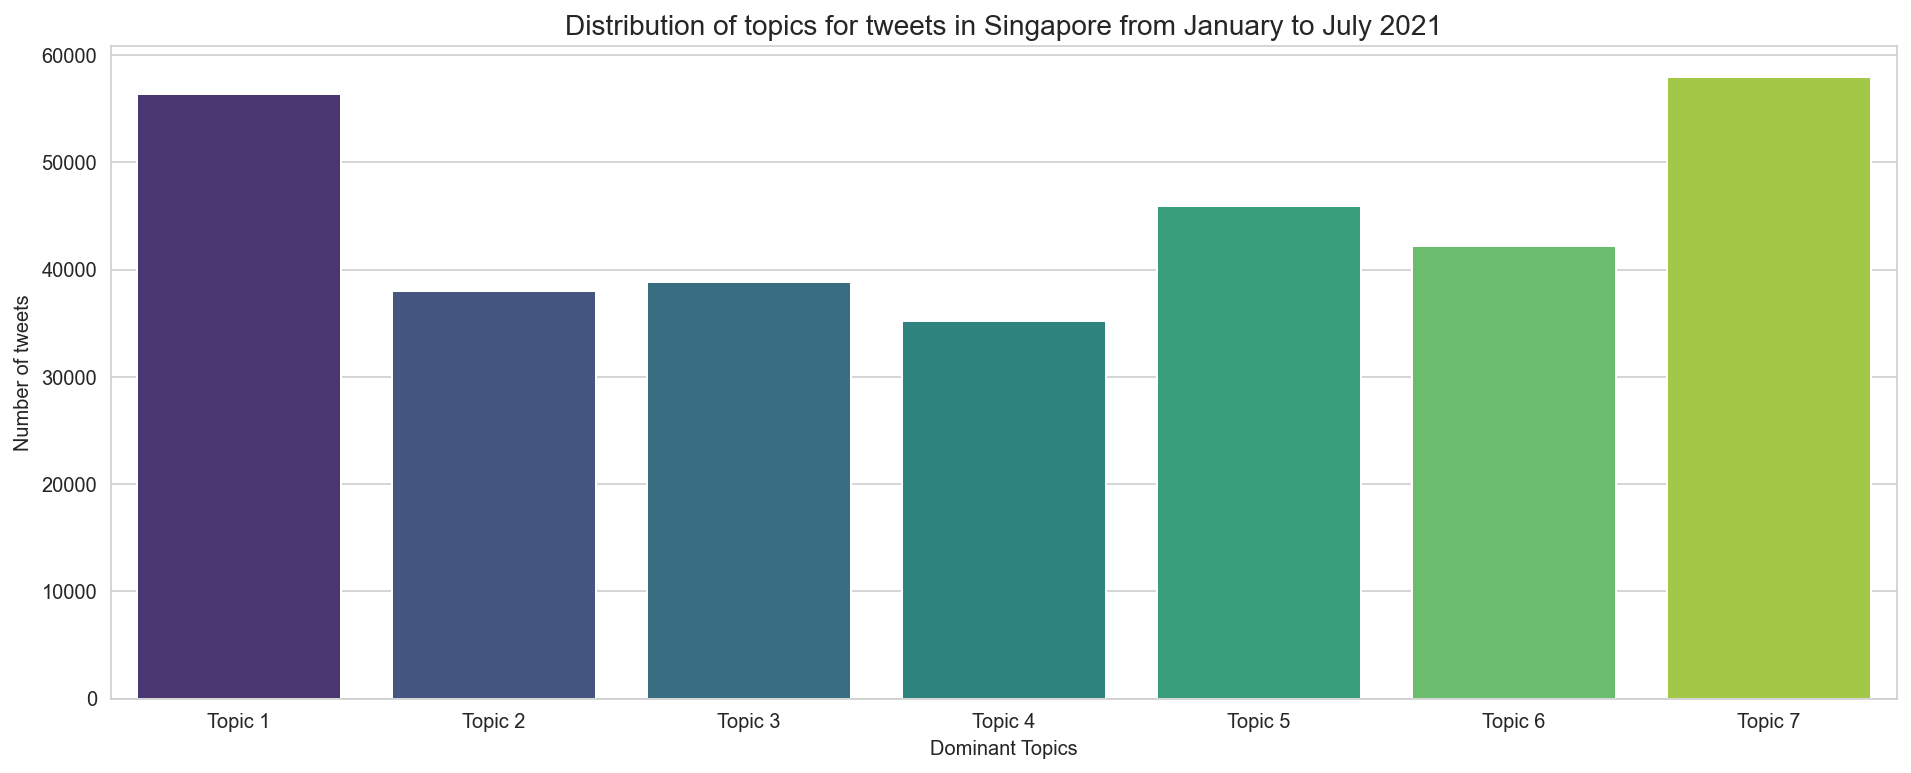

In [115]:
# view the distribution of topics
print('The overall distribution of the dominant topics for tweets from January to July 2021 is as follows:')
print(sg_tweets_sent_tm_df['dominant_topic'].value_counts(normalize=True).sort_index())

plt.figure(figsize=(16,6))
plt.title('Distribution of topics for tweets in Singapore from January to July 2021', fontsize=14)
ax = sns.countplot(x='dominant_topic', data=sg_tweets_sent_tm_df, palette='viridis')
ax.set(xlabel='Dominant Topics', ylabel='Number of tweets') 
topics = ['Topic 1', 'Topic 2', 'Topic 3', 'Topic 4', 'Topic 5', 'Topic 6', 'Topic 7']
ax.set_xticklabels(topics)

It can be observed that majority of tweets seem to be classified with dominant Topic 7 (18.4%), followed by Topic 1 (17.9%) and Topic 5 (14.6%). This seems plausible, as Topic 7 (related to political affairs in the United States of America) is under scrutiny by world leaders and is widely discussed across the globe, while Topic 1 (mixture of latest trends such as the Premier League games, COVID-19 cases and vaccinations) is at the top of our mind as it has impact on our day-to-day life. 

[Text(0, 0, 'Topic 1'),
 Text(1, 0, 'Topic 2'),
 Text(2, 0, 'Topic 3'),
 Text(3, 0, 'Topic 4'),
 Text(4, 0, 'Topic 5'),
 Text(5, 0, 'Topic 6'),
 Text(6, 0, 'Topic 7')]

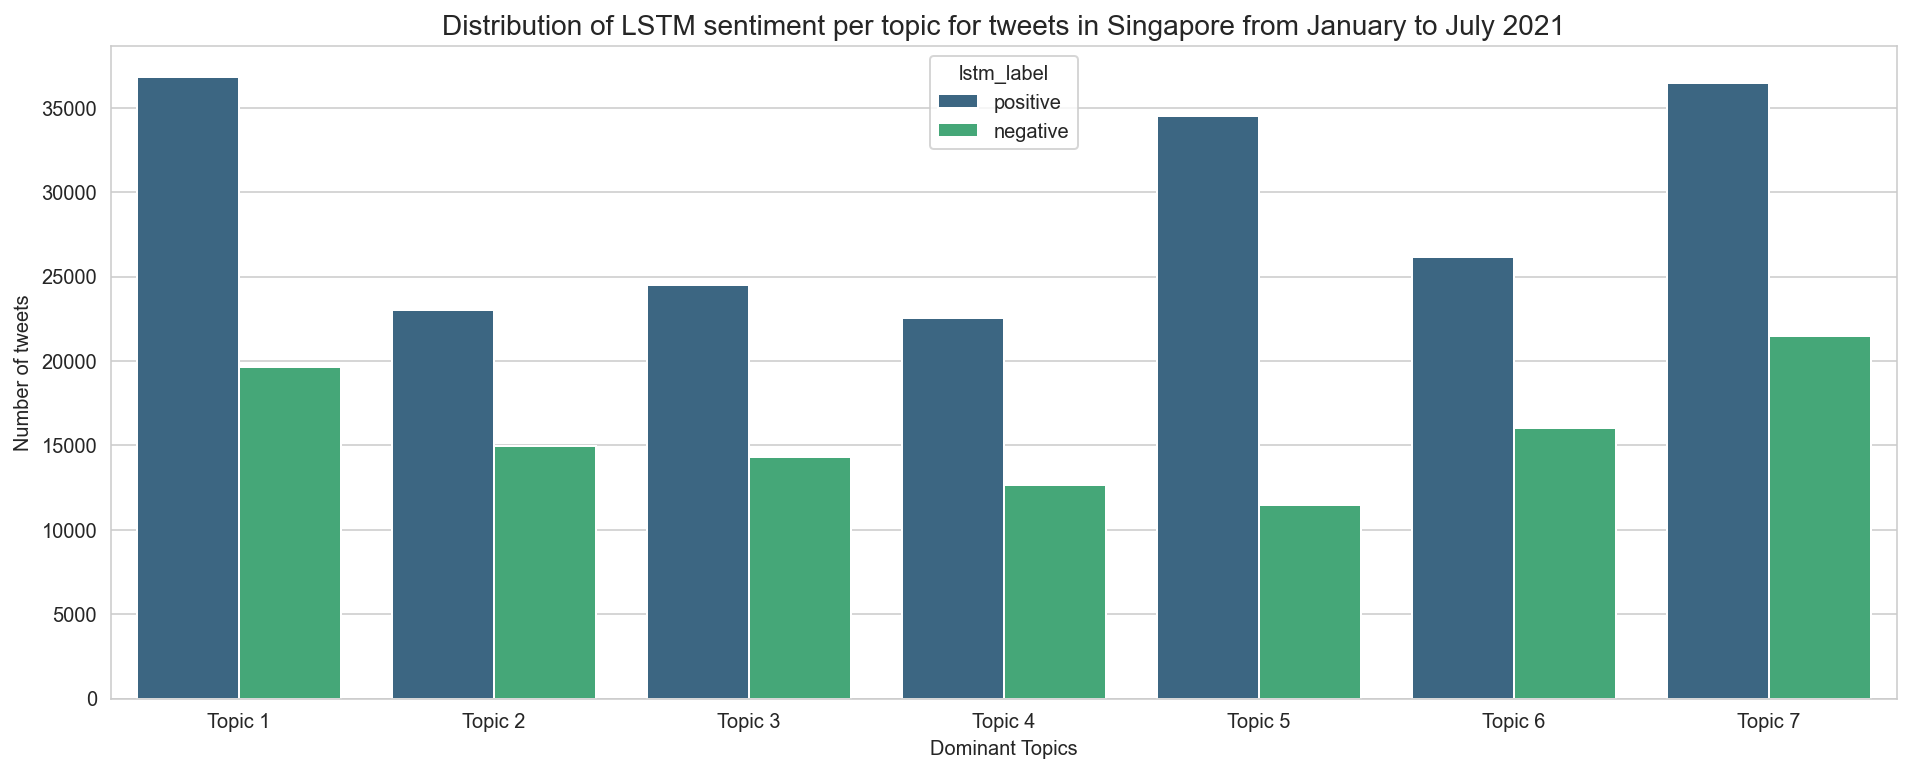

In [107]:
# view the distribution of topics and their split with sentiment
plt.figure(figsize=(16,6))
plt.title('Distribution of LSTM sentiment per topic for tweets in Singapore from January to July 2021', fontsize=14)
ax = sns.countplot(x='dominant_topic', data=sg_tweets_sent_tm_df, hue='lstm_label', palette='viridis')
ax.set(xlabel='Dominant Topics', ylabel='Number of tweets') 
topics = ['Topic 1', 'Topic 2', 'Topic 3', 'Topic 4', 'Topic 5', 'Topic 6', 'Topic 7']
ax.set_xticklabels(topics)

Generally, all topics have more positive than negative tweets, though it is worthwhile to note that some topics have a higher proportion of negative to positive tweets. For instance:

- Topic 2 has the smallest difference (gap) between the number of positive and negative tweets.  
    - As this topic is related to the military coup in Myanmar and with some form of reference to China's dictatorship, more users would have expressed their fear, uneasiness and anger over how the military has taken over the control of Myanmar and is terrorizing its people, therefore contributing to the negative sentiment. Users however still remain hopeful that the military will eventually be defeated, with support from global leaders. 
    
- Topic 5 has the largest difference (gap) between the number of positive and negative tweets. 
    - As this topic is related to recreational activities amidst COVID-19, such as exploring nature and food places as well as going on staycations, users tend to feel excited and happy when they are able to head out and explore in spite of the restrictions on dining-in and group sizes for social gathering, thereby contributing to the positive sentiment.

[Text(0, 0, 'Jan'),
 Text(1, 0, 'Feb'),
 Text(2, 0, 'Mar'),
 Text(3, 0, 'Apr'),
 Text(4, 0, 'May'),
 Text(5, 0, 'Jun'),
 Text(6, 0, 'Jul')]

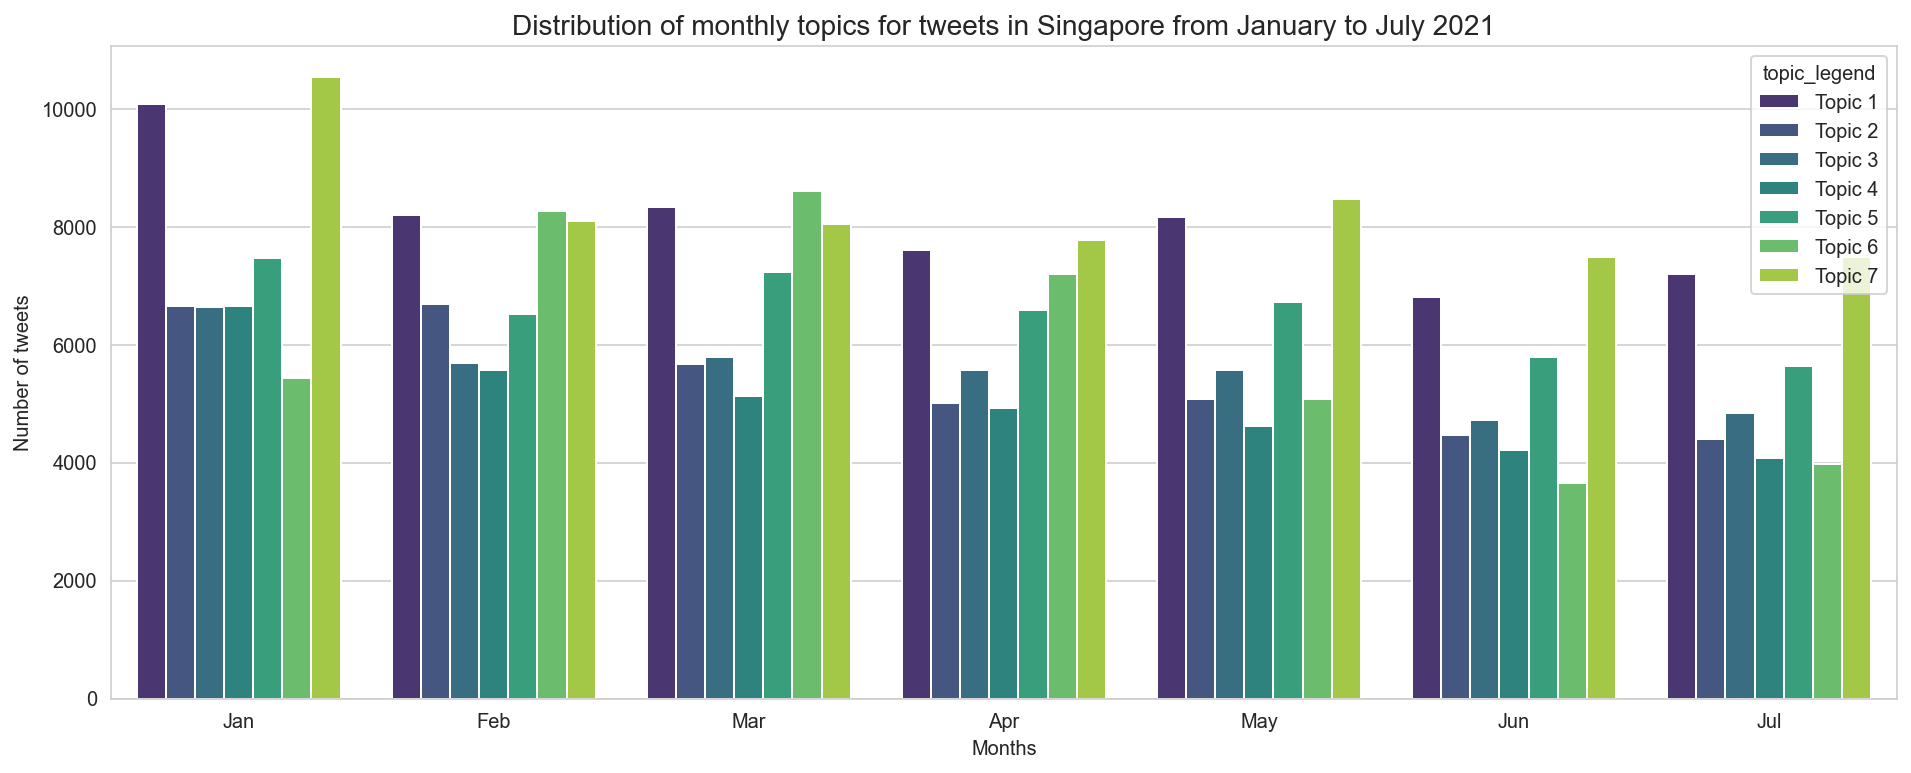

In [114]:
# view the distribution of topics by months
plt.figure(figsize=(16,6))
plt.title('Distribution of monthly topics for tweets in Singapore from January to July 2021', fontsize=14)
ax = sns.countplot(x='month', data=sg_tweets_sent_tm_df, hue='dominant_topic', palette='viridis')
plt.legend(labels=['Topic 1', 'Topic 2', 'Topic 3', 'Topic 4', 'Topic 5', 'Topic 6', 'Topic 7'], title='topic_legend')
ax.set(xlabel='Months', ylabel='Number of tweets') 
months = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul']
ax.set_xticklabels(months)

It can be observed that Topic 7 remains one of the most commonly discussed topic across the months, peaking in January 2021, followed by in May to July 2021. 
- Tracing to the series of events that occurred in January 2021, a group of President Donald Trump's supporters attacked the United States Capitol in Washington, D.C. on 6 January 2021 to overturn his defeat in the 2020 presidential election. This was carried out to disrupt the joint session of Congress that would formalize President-elect Joe Biden's victory (source: [Wikipedia, Jan 2021](https://en.wikipedia.org/wiki/2021_United_States_Capitol_attack)).

Topic 1 is the next most commonly discussed topic across the months, given its relevance to the current situation about COVID-19 cases and vaccination, as well as trending topics such as the Premier League games. 
- Particularly in January 2021, Phase 3 reopening of Singapore was introduced, and vaccination for healthcare workers started. 
- In the following months, announcements on the number of new COVID-19 confirmed cases and clusters were made, with restrictions on dining-in and group sizes for social gathering, alongside the people eligible for COVID-19 vaccinations.
- The Premier League games, which started on 12 September 2020, had reached its halfway point towards the end of January 2021.

Topic 6 seems to have grown in popularity between February to April 2021, before it becomes less frequently discussed after May 2021. 

### 5. Conclusion & Recommendations

As a recap, in this project, I'm keen to understand how people in Singapore are adapting to life in the "new normal" – a pandemic-filled era – ever since the COVID-19 pandemic started more than a year ago. To do so, I have analysed tweets in Singapore over a period of seven months, from 1 January 2021 to 31 July 2021. 

From the Sentiment Analysis, it can be observed that 64.9% of the tweets (close to two thirds) have positive sentiment, whereas the remaining 35.1% of them (slightly more than one third) have negative sentiment. This seems to indicate that people are generally positive about adapting to life in the "new normal", as the proportion of positive to negative sentiment for tweets remains relatively consistent over the first seven months in 2021.

For Topic Modelling, it has highlighted the dominant topics that people are discussing frequently on Twitter, from matters in Singapore such as the COVID-19 cases, clusters, vaccinations and new restrictions imposed by the government of Singapore to curb of the spread of COVID-19 cases in the community, to global issues such as the political affairs in the United States of America and military coup in Myanmar. Definitely, there are also topics related to day-to-day life, such as recreational places to explore, food places to visit, results from the Premier League games and even latest celebrity news. 

When comparing the sentiment to the dominant topics, it can be observed that the polarity scores vary from topic to topic, indicating the importance to analyse the sentiment for each topic in order to obtain a thorough understanding of the tweets. For instance, topics which have more positive sentiment are related to how people are looking forward to participating in recreational activities such as exploring nature and food places, going on staycations, etc. in spite of the COVID-19 pandemic. On the other hand, topics with more negative sentiment seem to be stemming from tweets related to global events such as the military coup in Myanmar and political affairs in the United States of America, which have the potential to disrupt world peace and security. 

Essentially, this serves as feedback for the government of Singapore to consider when introducing new measures or policies, such as: 

- **For implementation in Singapore:**

    - Ensuring timely and concise communication about new COVID-19 cases and clusters outbreak in Singapore, without inducing further anxiety and fear.
    - Easing COVID-19 restrictions imposed in the country whenever the situation permits, so that people are able to engage in activities which can boost their emotional health while abiding by the safety measures. 
    - Providing a range of resources, i.e. financial help, social support helplines, etc. to help people who may be struggling during the pandemic.


- **For handling global affairs:** 
    - Providing humanitarian aid for people affected in the military coup in Myanmar. 
    - Partaking in discussions with global leaders to resolve issues surrounding humanity.

### 6. Limitations & Further Explorations

Some of the **limitations** for this project include: 
- As there is a lack of labelled tweets from Singapore online, I have utilised labelled tweets from Sentiment140, which may not be the most appropriate for predicting the sentiment of tweets in Singapore, as it does not take into consideration special words and slangs used in Singapore, i.e. Singlish. 
    - Besides, the labelled tweets only consist of positive and negative sentiment labels – tweets that are neutral in sentiment may be incorrectly classified as positive and negative.




Moving forward, these are some of the **exploration opportunities**:
- Building a pre-trained LSTM RNN model for Sentiment Analysis with all 1,600,000 labelled tweets from Sentiment140, and with hypertuning the parameters used in the model. 
- Conducting an Emotion Recognition Analysis, using a pre-trained emotion recognition RNN model from Colnerič & Demšar (source: [Colnerič & Demšar, 2018](https://github.com/nikicc/twitter-emotion-recognition)), to prediction emotions from the tweets. The six emotions that can be classified include anger, disgust, fear, joy, sadness and surprise.
- Understanding the correlation between the hashtags used in the tweets and the corresponding sentiment and emotion.
- Correlating the COVID-19 cases/death and COVID-19 vaccination status in Singapore with this analysis to monitor how attitudes are changing overtime. 
- Creating a Twitter user network analysis to identify Twitter users who are more influential in driving the topics of discussion on Twitter. 
- Expanding the datasets to include texts from other social media platforms such as Facebook and Reddit. 

In the [next notebook](./05_plotly_and_dash.ipynb), I will be consolidating some of the key visualizations into a dashboard, using Plotly and Dash and deploying onto PythonAnywhere, allowing for easier reference to trends, sentiment and topics of Singapore tweets from January to July 2021.